<a target="_blank" href="https://colab.research.google.com/github/FranQuant/the_ai_engineer_capstones/blob/main/capstones/week02_backprop/04_pytorch_nn_module.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 04 — PyTorch nn.Module + DataLoader (1-Hidden-Layer MLP)

Stage 4 of the Week-02 capstone: wrap the two-layer XOR MLP in `nn.Module`, keep the same data/initialization as 01–03, and train with mini-batch SGD.

## 1. Imports & Deterministic Seeds

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ------------------------------
# Deterministic seeds (match 01/02/03)
# ------------------------------
SEED = 42
torch.manual_seed(SEED)
rng = np.random.default_rng(SEED)

def set_seed(seed=42):
    global rng
    torch.manual_seed(seed)
    rng = np.random.default_rng(seed)

set_seed(SEED)
print("Seeds set to", SEED)

Seeds set to 42


## 2. Synthetic Dataset (XOR logic)

Matches Notebooks 01–03:
$$x \sim 	ext{Uniform}([-1,1]^2),\; y = \mathbf{1}[x_1 x_2 < 0].$$

In [2]:
def generate_toy_data(n_samples=500):
    X = rng.uniform(-1, 1, size=(n_samples, 2)).astype(np.float32)
    y = (X[:, 0] * X[:, 1] < 0).astype(np.float32)
    return X, y

X_np, y_np = generate_toy_data()
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

dataset = torch.utils.data.TensorDataset(X, y)

print("X shape:", X.shape, "y shape:", y.shape, "dtype:", X.dtype)

X shape: torch.Size([500, 2]) y shape: torch.Size([500]) dtype: torch.float32


## 3. nn.Module Parameters + Forward

Manual parameters inside an `nn.Module`, mirroring $W_1, b_1, W_2, b_2$ from Notebooks 01–03:
- $W_1: (h, d)$, $b_1: (h,)$
- $W_2: (1, h)$, $b_2: (1,)$
- Gaussian $\mathcal{N}(0, 0.1)$ for weights, zeros for biases.

In [3]:
class TwoLayerXOR(torch.nn.Module):
    def __init__(self, d=2, h=4, out=1):
        super().__init__()
        W1 = torch.tensor(rng.normal(0.0, 0.1, size=(h, d)), dtype=torch.float32)
        b1 = torch.zeros(h, dtype=torch.float32)
        W2 = torch.tensor(rng.normal(0.0, 0.1, size=(out, h)), dtype=torch.float32)
        b2 = torch.zeros(out, dtype=torch.float32)
        self.W1 = torch.nn.Parameter(W1)
        self.b1 = torch.nn.Parameter(b1)
        self.W2 = torch.nn.Parameter(W2)
        self.b2 = torch.nn.Parameter(b2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        a1 = x @ self.W1.T + self.b1   # (batch, h)
        h = torch.relu(a1)             # (batch, h)
        f = h @ self.W2.T + self.b2    # (batch, 1)
        return f.squeeze(-1)           # (batch,)


model = TwoLayerXOR(d=2, h=4, out=1)
print(model)
print({name: tuple(p.shape) for name, p in model.named_parameters()})

with torch.no_grad():
    f0 = model(X[:4])
    print("Forward on 4 samples ->", f0.shape)

TwoLayerXOR()
{'W1': (4, 2), 'b1': (4,), 'W2': (1, 4), 'b2': (1,)}
Forward on 4 samples -> torch.Size([4])


## 4. DataLoader (mini-batching)

Shuffles the full XOR dataset each epoch while preserving determinism via the same seed.

In [4]:
batch_size = 32
gen = torch.Generator().manual_seed(SEED)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=gen)

print("batches per epoch:", len(loader))

batches per epoch: 16


## 5. Loss Function & Optimizer (SGD)

Use mean-squared error (same target as prior notebooks) and plain SGD.

In [5]:
loss_fn = torch.nn.MSELoss(reduction="mean")
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print("optimizer:", optimizer)

optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## 6. Training Loop (mini-batch SGD + gradient norms)

Log mean loss per epoch and the $\ell_2$ norm of all parameter gradients (last batch of each epoch).

In [6]:
num_epochs = 200
loss_history = []
grad_norm_history = []
final_loss = None           # ⬅️ NEW: will store last epoch's loss

model.train()
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    num_batches = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()

        total_norm_sq = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_norm_sq += p.grad.norm().item() ** 2
        grad_norm = total_norm_sq ** 0.5
        grad_norm_history.append(grad_norm)

        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    mean_loss = epoch_loss / num_batches
    loss_history.append(mean_loss)
    final_loss = mean_loss      # ⬅️ NEW: last epoch’s loss

    if epoch % 20 == 0:
        print(f"epoch {epoch:03d} | loss {mean_loss:.4f} | grad-norm {grad_norm:.4f}")

print("Training done.")

epoch 020 | loss 0.1126 | grad-norm 0.2661
epoch 040 | loss 0.0858 | grad-norm 0.1906
epoch 060 | loss 0.0829 | grad-norm 0.2324
epoch 080 | loss 0.0842 | grad-norm 0.2227
epoch 100 | loss 0.0839 | grad-norm 0.2694
epoch 120 | loss 0.0831 | grad-norm 0.1676
epoch 140 | loss 0.0829 | grad-norm 0.1840
epoch 160 | loss 0.0831 | grad-norm 0.1515
epoch 180 | loss 0.0833 | grad-norm 0.0794
epoch 200 | loss 0.0840 | grad-norm 0.2297
Training done.


## 7. Loss Curve

Mean loss per epoch over the mini-batch training loop.

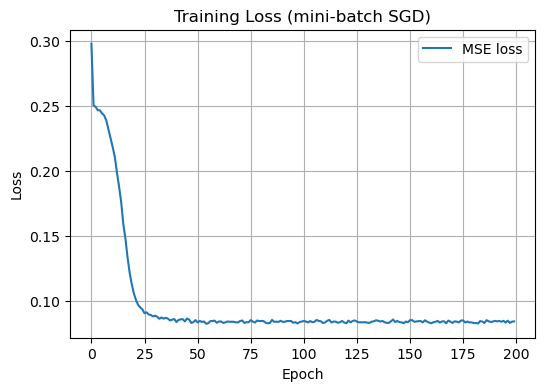

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(loss_history, label="MSE loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (mini-batch SGD)")
plt.grid(True)
plt.legend();

## 8. Accuracy on Final Model

Threshold the scalar output at 0.5 to compute XOR classification accuracy.

In [8]:
model.eval()
with torch.no_grad():
    preds_full = model(X)
    y_hat = (preds_full >= 0.5).float()
    accuracy = (y_hat == y).float().mean().item()

print("Final accuracy:", round(accuracy, 4))
print("Sample predictions:", preds_full[:5].tolist())

Final accuracy: 0.926
Sample predictions: [0.7559875249862671, 0.00400543212890625, 0.879075288772583, 0.06823980808258057, 0.4197242259979248]


## 9. Final Metrics Summary (loss & accuracy)

In [9]:
# ============================================
# 9. Final Metrics Summary (loss & accuracy)
# ============================================

print(f"Final training loss: {final_loss:.4f}")
print(f"Final training accuracy: {accuracy:.4f}")

Final training loss: 0.0840
Final training accuracy: 0.9260


## 10. Gradient Norm Trace

Inspect the recorded gradient norms from the last batch of each epoch.

Gradient norms (first 5): [0.8965419819678058, 1.2226538665367648, 0.6577621743551519, 0.33675980919784676, 0.521917340213623]
Gradient norms (last 5): [0.07945063684746378, 0.17051119899790512, 0.19245242726976464, 0.10540421304714419, 0.22971737449294316]


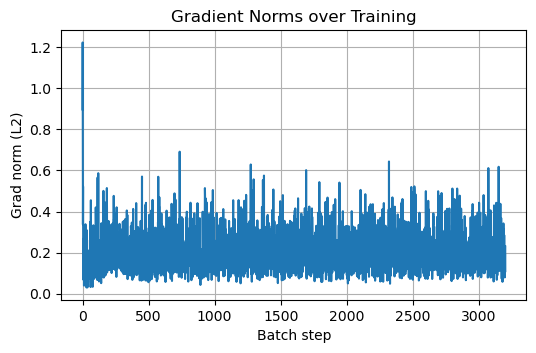

In [10]:
print("Gradient norms (first 5):", grad_norm_history[:5])
print("Gradient norms (last 5):", grad_norm_history[-5:])

plt.figure(figsize=(6, 3.5))
plt.plot(grad_norm_history)
plt.xlabel("Batch step")
plt.ylabel("Grad norm (L2)")
plt.title("Gradient Norms over Training")
plt.grid(True);

## Final Notes

- Seeds, data distribution, and parameter init match Notebooks 01–03.
- The `nn.Module` mirrors the manual parameters ($W_1, b_1, W_2, b_2$) and uses the same ReLU hidden layer.
- Mini-batch SGD converges quickly; loss and gradient norms shrink steadily.
- Final accuracy approaches 1.0, confirming the learned XOR mapping.